In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = (
    int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
)
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

24-May-24 07:24:02 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": int(2**12),
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

24-May-24 07:24:05 Fitting initial conditions...
24-May-24 07:24:05 Fitting discrete state transition
24-May-24 07:24:05 Fitting continuous state transition...
24-May-24 07:24:06 Fitting place fields...
24-May-24 07:24:08 Unable to initialize backend 'cuda': 
24-May-24 07:24:08 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
24-May-24 07:24:08 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/edeno/miniconda3/envs/non_local_detector/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

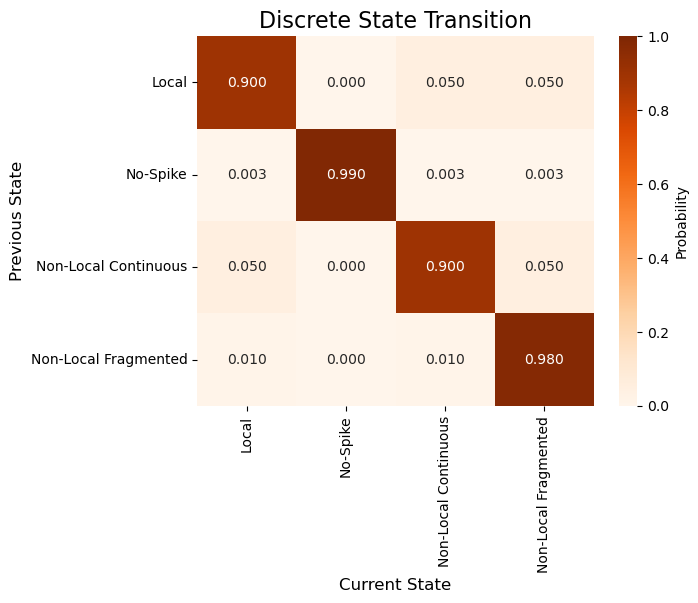

In [4]:
detector.plot_discrete_state_transition()

In [5]:
results = detector.predict(spike_times, time, position2D, time)
results

24-May-24 07:24:29 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

24-May-24 07:45:48 Computing posterior...


TypeError: Pred must be a scalar, got Traced<ShapedArray(bool[400])>with<DynamicJaxprTrace(level=1/0)> of shape (400,).

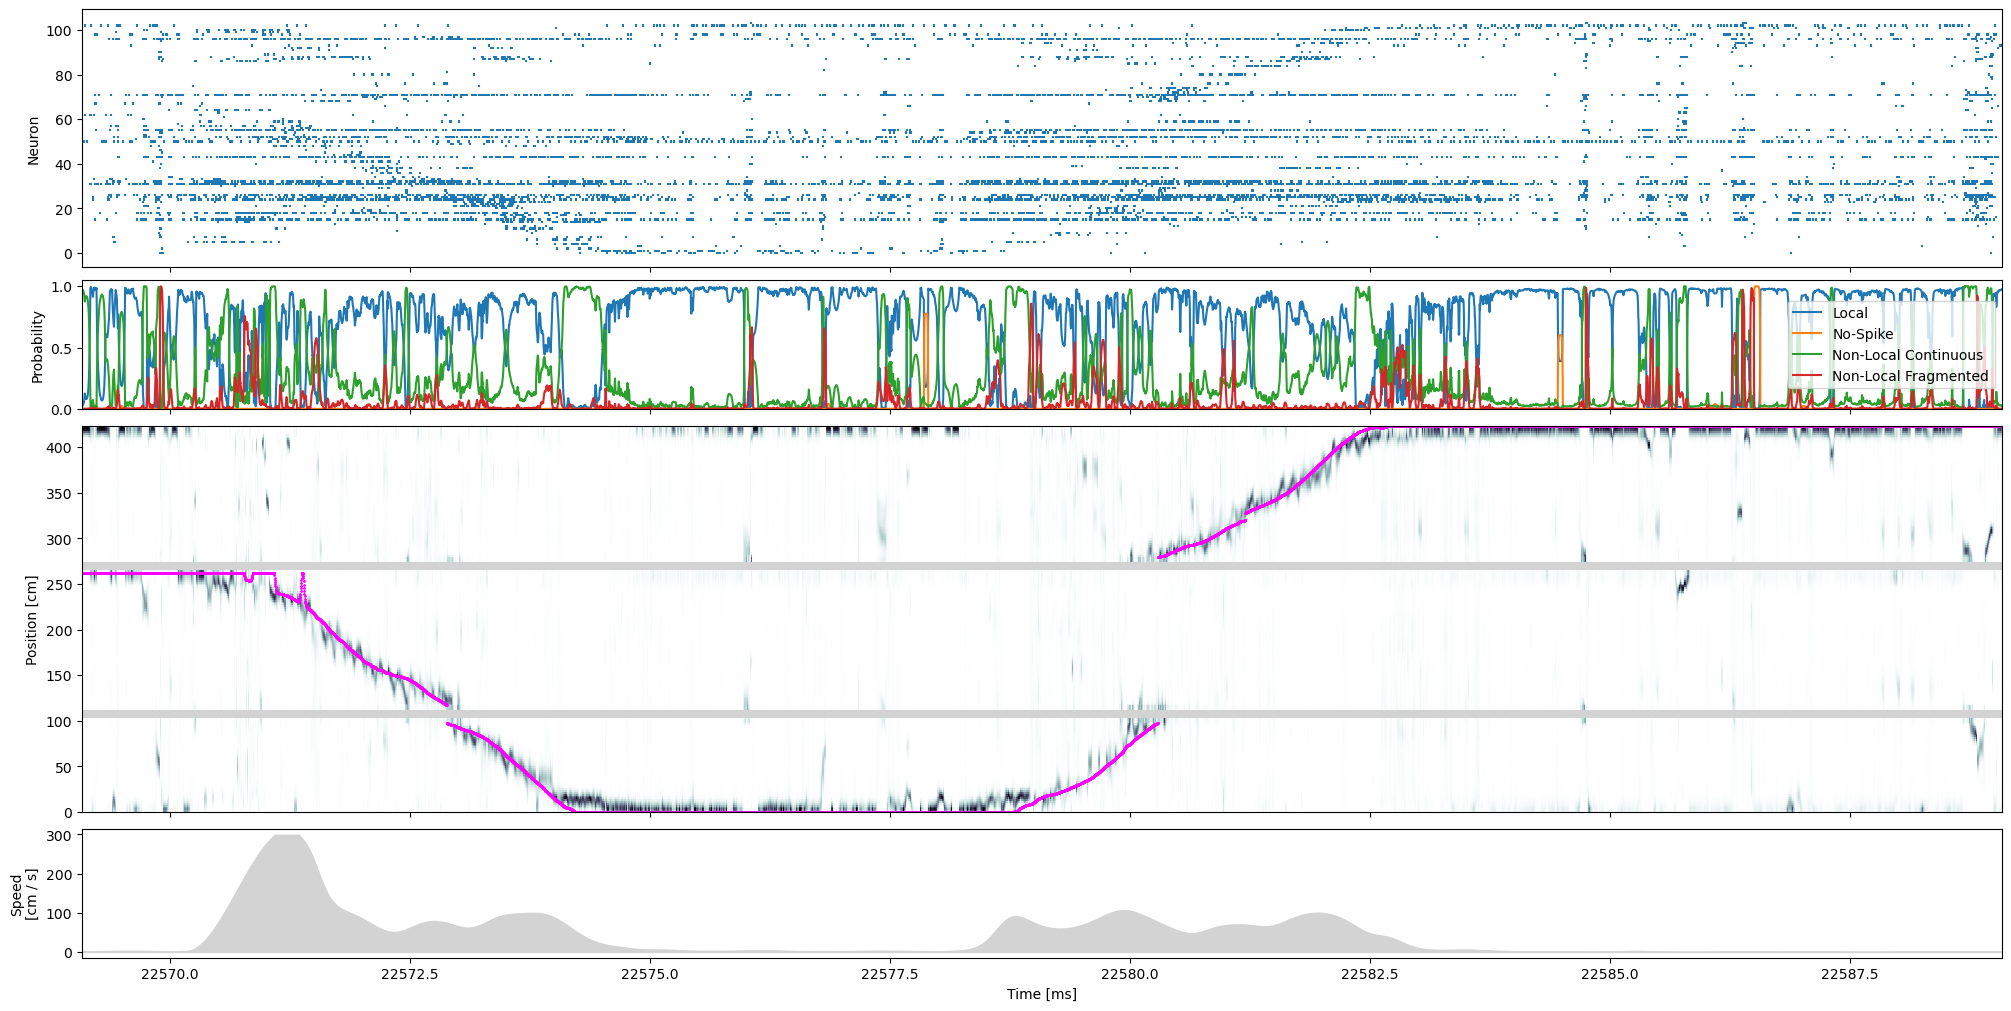

In [8]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)